In [429]:
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split

dataPath = '../PedestrianData/IntentionData'
pd.__version__

'0.24.2'

#### Loading the demographic and environmental data from pickle:

In [430]:
data = pd.read_pickle('../PedestrianData/Rafael.pkl')
list(data)

['File',
 'Scenario',
 'Wait Time (s)',
 'PET (s)',
 'Distace to Collision Point',
 'Card ID',
 'Speed Limit',
 'Lane Width',
 'Minimum Gap',
 'Mean Arrival Rate',
 'AV',
 'Full Braking Before Impact_-1.0',
 'Full Braking Before Impact_1',
 'Full Braking Before Impact_2',
 'Full Braking Before Impact_3',
 'Snowy',
 'One way',
 'two way',
 'Two way with median',
 'Night',
 'name',
 'numcars',
 'Vrexpnum',
 'Age_9-12',
 'Age_15-18',
 'Age_12-15',
 'Age_18 - 24',
 'Age_25 - 29',
 'Age_30 - 39',
 'Age_40 - 49',
 'Age_50 - 59',
 'Age_60+',
 'Gender_Female',
 'Occupation_Employed',
 'Occupation_Student',
 'Occupation_Unemployed',
 'Occupation_kid',
 'Education_Bachelors degree',
 'Education_College/University student',
 'Education_Doctorate degree',
 'Education_High school diploma',
 'Education_Masters degree',
 'Education_Professional degree',
 'driving license_Yes',
 'mode_Bike',
 'mode_Car',
 'mode_Public Transit',
 'mode_Walking',
 'workwalk_No',
 'workwalk_Sometimes',
 'workwalk_Yes',
 

#### Removing folder names from file values (some files are in subfolders)
#### Cleasing data that contain errors

In [431]:
for i in range(len(data)):
    value = data['File'].values[i].split('/')
    data['File'].values[i] = value[len(value) - 1]
    data['Wait Time (s)'] == "Err2"
    
data = data[data['Wait Time (s)'] != "Err1"]
data = data[data['Wait Time (s)'] != "Err2"]
data = data[data['Wait Time (s)'] != "Err3"]
data = data[data['Wait Time (s)'] != "Err4"]
data = data[data['Wait Time (s)'] != "Err5"]
data = data[data['Wait Time (s)'] != 0]
    
data.shape

(3410, 65)

## Curating final set of possible features

In [444]:
files = os.listdir(dataPath)

# [Cross, OneWay, Snowy, ]
features = np.empty((len(files), 14), dtype=list)

for i in range(len(files)):
    count = 0
    file = dataPath + "/" + files[i]
    df = pd.read_csv(file, sep=",", header=None, 
                 names=["Time", 
                        "Pos_x", "Pos_y", "Pos_z", 
                        "Gaz_x", "Gaz_y", "Gaz_z", 
                        "Vel_x", "Vel_z",
                        "Acc_x", "Acc_z",
                        "Vel_Mag", "Acc_Mag",
                        "Vel_Ang", "Acc_Ang", "Gaz_Ang",
                        "Vel_Bin", "Acc_Bin", "Gaz_Bin", "Chg_Bin"          
                       ])
    try:
        features[i, 0] = (data.loc[data['File'] == files[i]])["Wait Time (s)"].item()
        features[i, 1] = (data.loc[data['File'] == files[i]])["Lane Width"].item()
        features[i, 2] = (data.loc[data['File'] == files[i]])["One way"].item()
        features[i, 3] = (data.loc[data['File'] == files[i]])["Snowy"].item()
        features[i, 4] = (data.loc[data['File'] == files[i]])["Night"].item()
        features[i, 5] = (data.loc[data['File'] == files[i]])["Speed Limit"].item()
        features[i, 6] = (data.loc[data['File'] == files[i]])["Mean Arrival Rate"].item()

    except:
        features[i, 0] = 0
        features[i, 1] = 0
        features[i, 2] = 0
        features[i, 3] = 0
        features[i, 4] = 0
        features[i, 5] = 0
        features[i, 6] = 0
    finally:
        bins = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0]
        for j in range(len(bins)):
            features[i, j+7] = bins[j]
        
        
        #features[i, 3] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][0]
        #features[i, 4] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][1]
        #features[i, 5] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][2]
        #features[i, 6] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][3]
        #features[i, 7] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][4]
        #features[i, 8] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][5]
        #features[i, 9] = np.histogram(np.array(df["Gaz_Bin"]), bins=[1, 2, 3, 4, 5, 6, 7, 8], density=False)[0][6]
        
# Removing data with crossing time of '0'
features = features[features[:, 0] != 0]

#final_df = pd.DataFrame(bin_data, columns=('Wait Time', 'Width', 'Type', 'Gaz_Bin', "Chg_Bin"))

# Validating data types in the dataset
#np.unique([str(datum.dtype) for datum in features[:,3]])

# Testing regression models

### Decision Tree

Trained with:  1174
Tested with:  294
R^2 (coefficient of determination) regression score function: 0.47922375227262004
Mean Absolute Error: 3.9465420119047625
Mean Squared Error: 52.86067107097206
Root Mean Squared Error: 7.270534441908109


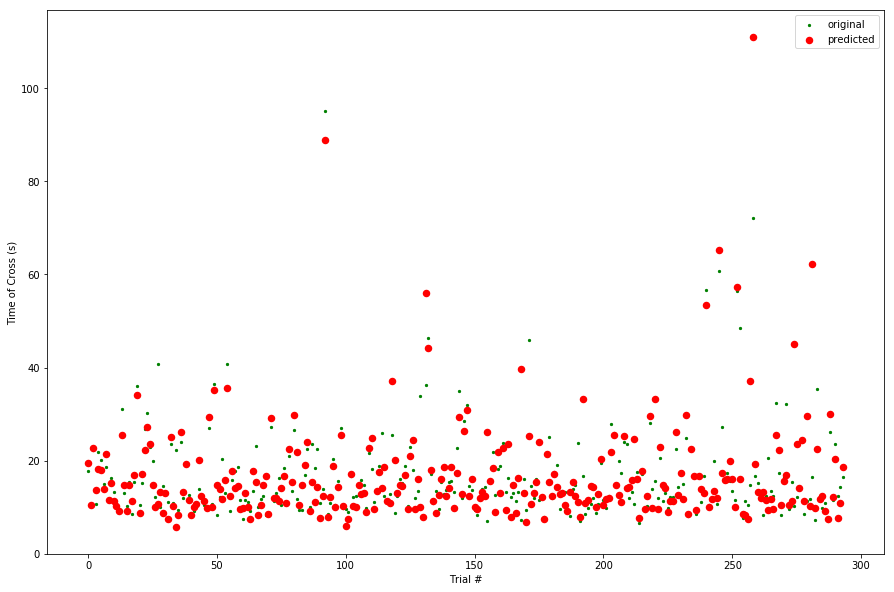

In [455]:
def getData(N):
    x,y =[],[]
    for i in range(N):
        c = [features[i,1], features[i,2], features[i,3], 
             features[i,4], features[i,5], features[i,6], 
             features[i,7], features[i,8], features[i,9], 
             features[i,10], features[i,11], features[i,12], 
             features[i,13]]
        yy = features[i, 0]
        x.append(c)
        y.append(yy)
    return np.array(x), np.array(y)

X,y=getData(len(features))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
regressor = DecisionTreeRegressor()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)  

print("Trained with: ", len(X_train))
print("Tested with: ", len(X_test))
print('R^2 (coefficient of determination) regression score function:', metrics.r2_score(y_test,y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

x_ax=range(len(y_pred))
plt.figure(figsize=(15, 10)) 
plt.scatter(x_ax, y_test, s=5, color="green", label="original")
plt.scatter(x_ax, y_pred, lw=1.5, color="red", label="predicted")
    
plt.xlabel("Trial #")
plt.ylabel("Time of Cross (s)")
plt.legend()
plt.show()

Scores: [ 6.94204491 10.66656483  6.3345192   6.2096734   5.40385161  5.2045311
  9.90070105  8.19490247  8.01871002  5.30253518]
Mean: 7.217803376153691
Standard deviation: 1.8322818516549937


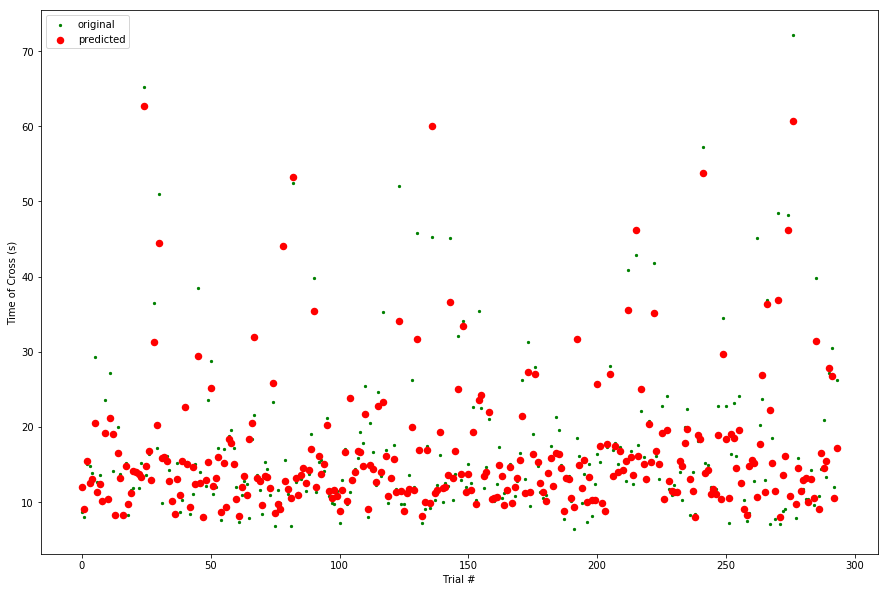

In [475]:
def getData(N):
    x,y =[],[]
    for i in range(N):
        c = [features[i,1], features[i,2], features[i,3], 
             features[i,4], features[i,5], features[i,6], 
             features[i,7], features[i,8], features[i,9], 
             features[i,10], features[i,11], features[i,12], 
             features[i,13]]
        yy = features[i, 0]
        x.append(c)
        y.append(yy)
    return np.array(x), np.array(y)

X,y=getData(len(features))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
forest_reg = RandomForestRegressor(bootstrap = True, n_estimators = 50)  
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)  

#print('R^2 (coefficient of determination) regression score function:', metrics.r2_score(y_test,y_pred))
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

cross_val_score(forest_reg, X, y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

x_ax=range(len(y_pred))
plt.figure(figsize=(15, 10)) 
plt.scatter(x_ax, y_test, s=5, color="green", label="original")
plt.scatter(x_ax, y_pred, lw=1.5, color="red", label="predicted")
    
plt.xlabel("Trial #")
plt.ylabel("Time of Cross (s)")
plt.legend()
plt.show()

In [468]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bootstrap': [True], 'n_estimators': [10, 50, 100, 250, 500]},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100, 250, 500]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'bootstrap': True, 'n_estimators': 50}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
